In [1]:
import os
import numpy as np
import tifffile

def load_into_3d_array(folder_path, z_start, z_end, new_img_size=3000):
    # Initialize an empty list to hold 2D image slices
    slices = []
    
    # Sort the files to load them in order
    files = sorted(os.listdir(folder_path))
    
    # Load first one and check the shape
    filepath = os.path.join(folder_path, files[z_start])
    img_slice = tifffile.imread(filepath)
    
    new_img_size = 3000
    img_size_x, img_size_y = img_slice.shape
    random_offset_x = np.random.randint(0, img_size_x - new_img_size)
    random_offset_y = np.random.randint(0, img_size_y - new_img_size)
    slices = [img_slice[random_offset_x:random_offset_x+new_img_size, random_offset_y:random_offset_y+new_img_size]]
    
    for file in files[z_start+1:z_end]:
        if file.endswith('.tif'):
            filepath = os.path.join(folder_path, file)
            
            # Read a .tif image file
            img_slice = tifffile.imread(filepath)[random_offset_x:random_offset_x+new_img_size, random_offset_y:random_offset_y+new_img_size]
            
            # Append to list
            slices.append(img_slice)
            
    # Stack along a new third dimension to make a 3D array
    stack = np.stack(slices, axis=2)
    
    return stack


In [2]:

# Usage
folder_path = '/home/viktor/Documents/kaggle/vesuvius-challenge/data/kaggle-data/train/1/surface_volume'  # Replace with the path to your 'surface_volume' folder
%timeit three_d_array = load_into_3d_array(folder_path, z_start=8, z_end=18) # ~ 500ms per loop


494 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
import os
import zarr
import tifffile
import numpy as np
import imageio

# Path to your TIFF files and mask
root_dir = "/home/viktor/Documents/kaggle/vesuvius-challenge/data/kaggle-data/train/1"
tif_folder = f"{root_dir}/surface_volume"
mask_path = f"{root_dir}/mask.png"

# Read mask image
mask_data = imageio.imread(mask_path)

# Initialize the Zarr file
zarr_file = "output.zarr"
root = zarr.open_group(zarr_file, mode='w')

# Create 3D Zarr array for volume
first_tif = tifffile.imread(os.path.join(tif_folder, "00.tif"))
z_shape, y_shape, x_shape = len(os.listdir(tif_folder)), first_tif.shape[0], first_tif.shape[1]
volume = root.create_dataset("volume", shape=(z_shape, y_shape, x_shape), chunks=(1, y_shape, x_shape), dtype=first_tif.dtype)

# Create 2D Zarr array for truth (mask)
truth = root.create_dataset("truth", shape=mask_data.shape, chunks=mask_data.shape, dtype=mask_data.dtype)
truth[:] = mask_data  # Write mask data to Zarr array

# Read each TIFF file and write to Zarr array
print(f"Reading TIFF files")
for i, filename in enumerate(sorted(os.listdir(tif_folder))):
    if filename.endswith(".tif"):
        tif_path = os.path.join(tif_folder, filename)
        tif_data = tifffile.imread(tif_path)
        
        # Make sure to validate the shape and dtype of each TIFF if needed
        assert tif_data.shape == (y_shape, x_shape)
        assert tif_data.dtype == first_tif.dtype
        
        # Write the TIFF data to the Zarr array
        volume[i, :, :] = tif_data

print(f"Zarr file {zarr_file} has been created with datasets .volume and .truth")


/tmp/ipykernel_3778569/3872868104.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_data = imageio.imread(mask_path)


Processing 00.tif
Processing 01.tif
Processing 02.tif
Processing 03.tif
Processing 04.tif
Processing 05.tif
Processing 06.tif
Processing 07.tif
Processing 08.tif
Processing 09.tif
Processing 10.tif
Processing 11.tif
Processing 12.tif
Processing 13.tif
Processing 14.tif
Processing 15.tif
Processing 16.tif
Processing 17.tif
Processing 18.tif
Processing 19.tif
Processing 20.tif
Processing 21.tif
Processing 22.tif
Processing 23.tif
Processing 24.tif
Processing 25.tif
Processing 26.tif
Processing 27.tif
Processing 28.tif
Processing 29.tif
Processing 30.tif
Processing 31.tif
Processing 32.tif
Processing 33.tif
Processing 34.tif
Processing 35.tif
Processing 36.tif
Processing 37.tif
Processing 38.tif
Processing 39.tif
Processing 40.tif
Processing 41.tif
Processing 42.tif
Processing 43.tif
Processing 44.tif
Processing 45.tif
Processing 46.tif
Processing 47.tif
Processing 48.tif
Processing 49.tif
Processing 50.tif
Processing 51.tif
Processing 52.tif
Processing 53.tif
Processing 54.tif
Processing

In [14]:
root.volume[0, 0:10, 0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint16)

In [9]:
output.volume

NameError: name 'output' is not defined

In [10]:
x = zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-1.zarr", mode="r")

PathNotFoundError: nothing found at path ''

In [1]:
from typing import *
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
import os
import zarr
import tifffile
import imageio
import numpy as np
from tqdm import tqdm


def get_zarr_file(folder: str, z_start: int = 0, z_end: int = None) -> zarr.core.Array:
    """
    Create an in-memory Zarr store from a given folder.
    zarr .volume is uint16, mask and label are uint8
    """

    # Paths to TIFF, mask, and labels
    tif_folder = f"{folder}/surface_volume"
    mask_path = f"{folder}/mask.png"
    label_path = f"{folder}/inklabels.png" if os.path.exists(f"{folder}/inklabels.png") else None

    # Read mask and labels
    mask_data = imageio.imread(mask_path, pilmode='L')
    label_data = imageio.imread(label_path, pilmode='L') if label_path else None


    # Initialize in-memory Zarr store
    store = zarr.MemoryStore()
    root = zarr.group(store=store)

    # Create Zarr array for mask
    mask_zarr = root.create_dataset("mask", shape=mask_data.shape, chunks=mask_data.shape, dtype=mask_data.dtype)
    mask_zarr[:] = mask_data

    # Create Zarr array for label if it exists
    if label_data is not None:
        label_zarr = root.create_dataset("label", shape=label_data.shape, chunks=label_data.shape, dtype=label_data.dtype)
        label_zarr[:] = label_data

    # Get list of TIFF files and apply slicing
    tif_files = sorted([f for f in os.listdir(tif_folder) if f.endswith('.tif')])[z_start:z_end]

    # Read first TIFF to determine shape and dtype
    first_tif_path = os.path.join(tif_folder, tif_files[0])
    first_tif = tifffile.imread(first_tif_path)

    # Create 3D Zarr array for volume
    z_shape, y_shape, x_shape = len(tif_files), first_tif.shape[0], first_tif.shape[1]
    volume = root.create_dataset("volume", shape=(z_shape, y_shape, x_shape), chunks=(1, y_shape, x_shape), dtype=first_tif.dtype)

    # Read each TIFF file and write to Zarr array
    print(f"Reading TIFF files from folder {tif_folder}")
    for i, filename in tqdm(enumerate(tif_files), total=z_shape):
        tif_path = os.path.join(tif_folder, filename)
        tif_data = tifffile.imread(tif_path)

        # Make sure to validate the shape and dtype of each TIFF if needed
        assert tif_data.shape == (y_shape, x_shape)
        assert tif_data.dtype == first_tif.dtype

        # Write the TIFF data to the Zarr array
        volume[i, :, :] = tif_data

    return root

In [2]:

root_dir = "/home/viktor/Documents/kaggle/vesuvius-challenge/data/kaggle-data/train/1"

# Create Zarr store from folder
root = get_zarr_file(root_dir, z_start=8, z_end=18)


/tmp/ipykernel_4055017/1992781192.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_data = imageio.imread(mask_path, pilmode='L')
/tmp/ipykernel_4055017/1992781192.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label_data = imageio.imread(label_path, pilmode='L') if label_path else None


Reading TIFF files from folder /home/viktor/Documents/kaggle/vesuvius-challenge/data/kaggle-data/train/1/surface_volume


100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


In [7]:
root.label[:].shape

(8181, 6330)

In [1]:
import sys
from kaggle_vesuvius.dataloaders import VesuviusDataset

train_dataset = VesuviusDataset(mode='train',
                                          data_dir='/home/viktor/Documents/kaggle/vesuvius-challenge/data/kaggle-data/train', 
                                          crop_size=256,
                                          eval_on=1,
                                          z_start=8,
                                          z_end=16,
                                          )

['1', '2', '3']
[2 3]


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Reading TIFF files from folder /home/viktor/Documents/kaggle/vesuvius-challenge/data/kaggle-data/train/2/surface_volume


100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Reading TIFF files from folder /home/viktor/Documents/kaggle/vesuvius-challenge/data/kaggle-data/train/3/surface_volume


100%|██████████| 8/8 [00:00<00:00, 22.23it/s]


{'2': (14830, 9506), '3': (7606, 5249)}
Fragments shape is {'2': (14830, 9506), '3': (7606, 5249)}
Creating train dataset


100%|██████████| 29/29 [00:01<00:00, 18.63it/s]

Dataset created. In total, n_crops=1998


In [2]:
train_dataset.fragments_zarr['2'].volume[:].max()

65535

tensor(1.0078)


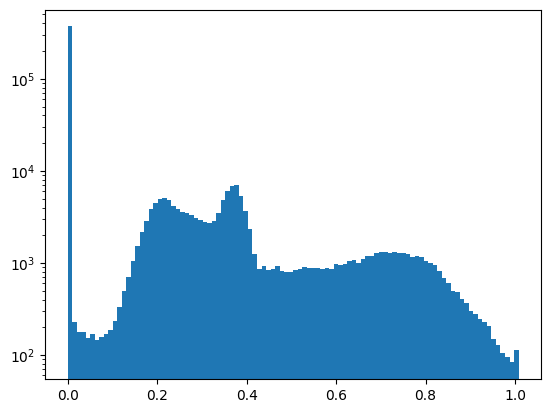

In [3]:
import matplotlib.pyplot as plt
import numpy as np


indx = np.random.randint(0, len(train_dataset))
x, y = train_dataset[indx]

print(x.max())
y2 = x.flatten()

plt.hist(y2, bins=100);

plt.yscale('log')

In [4]:
import yaml

config_path = "/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/baseline/config.yaml"


with open(config_path, "rb") as f:
    config = yaml.load(f, yaml.FullLoader)

from kaggle_vesuvius.model_builder import build_model
model = build_model(config)

In [5]:
x[0].shape

torch.Size([256, 256])

In [15]:
import  torch

indx = np.random.randint(0, len(train_dataset))
x, y = train_dataset[indx]


inputs = {'input_ids': x.unsqueeze(0)}
# inputs = {'input_ids': torch.randn(1, 8, 256, 256)}
y_pred = model(**inputs)

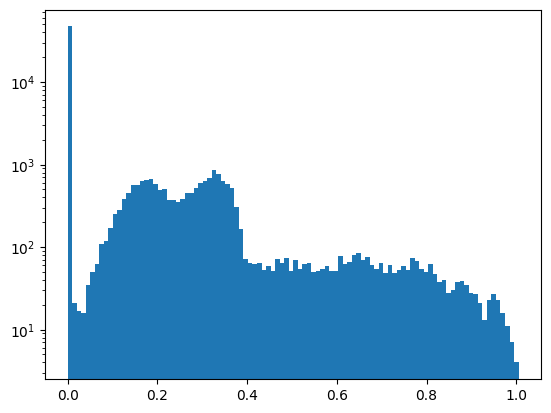

In [16]:
import matplotlib.pyplot as plt
y2 = x[0].flatten().cpu().detach().numpy()

plt.hist(y2, bins=100);

plt.yscale('log')

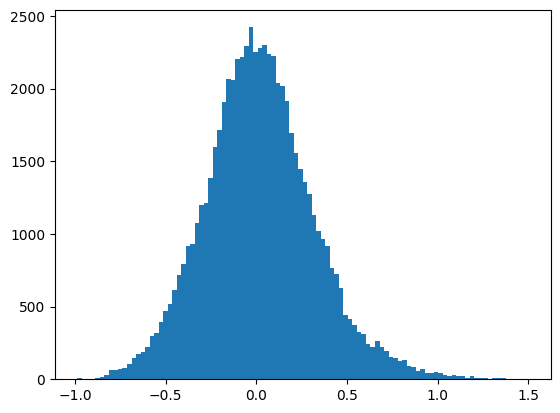

In [14]:
import matplotlib.pyplot as plt
y2 = y_pred.flatten().cpu().detach().numpy()

plt.hist(y2, bins=100);

In [15]:
x.shape, y.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [16]:
x[0].shape, x[1].shape

(torch.Size([1, 8, 256, 256]), torch.Size([256, 256]))

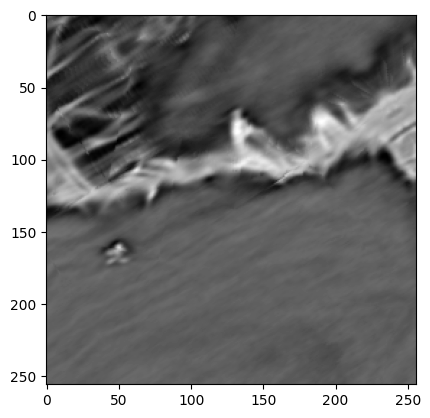

In [19]:
img = x[0][0, 0, :, :].numpy()
# visualize the image
import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray')

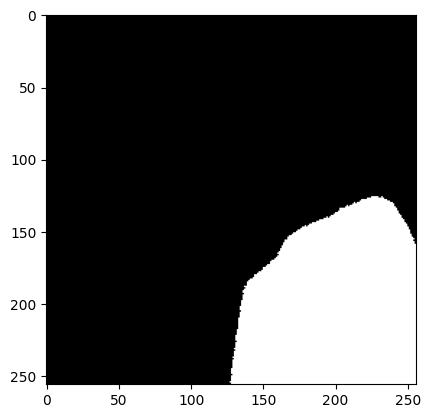

In [22]:
img = x[1][:, :].numpy()
# visualize the image
import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray')

In [1]:
from kaggle_vesuvius.losses import get_loss_function

loss_configs = [
        {
            "name": "bce",
            "params": {
                "weight": 0.5
            }
        },
        {
            "name": "dice",
            "params": {
                "weight": 0.5
            }
        }
    ]
criterion = get_loss_function(loss_configs)

In [1]:

from kaggle_vesuvius.models import resnet_3d, pvtv2


img_size = 256
in_chans = 8
num_classes = 1
model = pvtv2.PyramidVisionTransformerV2(img_size=img_size, 
                                            in_chans=in_chans, 
                                            num_classes=num_classes)

In [2]:
import torch

x = torch.randn(1, 8, 256, 256)
y = model(x)


In [4]:
y.shape

torch.Size([1, 1, 256, 256])

In [3]:
[el.shape for el in y]

[torch.Size([1, 64, 64, 64]),
 torch.Size([1, 128, 32, 32]),
 torch.Size([1, 256, 16, 16]),
 torch.Size([1, 512, 8, 8])]

In [5]:
import segmentation_models_pytorch as smp

In [11]:
encoder = smp.FPN(encoder_name="inceptionv4", encoder_weights=None, in_channels=8, classes=1).encoder

x = torch.randn(1, 8, 256, 256)
y = encoder(x)


In [12]:
[el.shape for el in y]

[torch.Size([1, 8, 256, 256]),
 torch.Size([1, 64, 128, 128]),
 torch.Size([1, 192, 64, 64]),
 torch.Size([1, 384, 32, 32]),
 torch.Size([1, 1024, 16, 16]),
 torch.Size([1, 1536, 8, 8])]

In [1]:

from kaggle_vesuvius.models import inceptionv4


img_size = 256
in_chans = 8
num_classes = 1
model = inceptionv4.InceptionV4FPN3DResNet(in_channels=8)

In [2]:
import torch
x = torch.randn(1, 8, 256, 256)
y = model(x)

In [3]:
y.shape

torch.Size([1, 1, 256, 256])